### Load libraries

In [1]:

import matplotlib.pyplot as plt
import pandas as pd
from cobra.flux_analysis import pfba
from cobra.flux_analysis.loopless import loopless_solution

import sys
sys.path.insert(0, '../scripts/')
from load_modify_sample_utils import load_model, get_objective_functions, get_reaction_bounds, modify_model
from load_modify_sample_utils import sample_dingo, sample_optgp
from loopless_utils import loops_enumeration_from_fva, get_loopless_solutions_from_samples, calculate_affected_samples
from loopless_utils import calculate_distances_from_samples, calculate_distances_from_reactions, violin_plot_samples_distances


/home/touliopoulos/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/touliopoulos/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/touliopoulos/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


### Load initial model

In [2]:
ec_cobra_model, ec_cobra_reactions, ec_dingo_model, ec_dingo_reactions = load_model("../ext_data/models/e_coli_core.xml")

objective_functions = get_objective_functions(ec_cobra_model)
print(objective_functions)

default_reaction_bounds = get_reaction_bounds(ec_cobra_model)
print(default_reaction_bounds)


Set parameter Username
Set parameter LicenseID to value 2642044
Academic license - for non-commercial use only - expires 2026-03-25
['BIOMASS_Ecoli_core_w_GAM']
{'PFK': (0.0, 1000.0), 'PFL': (0.0, 1000.0), 'PGI': (-1000.0, 1000.0), 'PGK': (-1000.0, 1000.0), 'PGL': (0.0, 1000.0), 'ACALD': (-1000.0, 1000.0), 'AKGt2r': (-1000.0, 1000.0), 'PGM': (-1000.0, 1000.0), 'PIt2r': (-1000.0, 1000.0), 'ALCD2x': (-1000.0, 1000.0), 'ACALDt': (-1000.0, 1000.0), 'ACKr': (-1000.0, 1000.0), 'PPC': (0.0, 1000.0), 'ACONTa': (-1000.0, 1000.0), 'ACONTb': (-1000.0, 1000.0), 'ATPM': (8.39, 1000.0), 'PPCK': (0.0, 1000.0), 'ACt2r': (-1000.0, 1000.0), 'PPS': (0.0, 1000.0), 'ADK1': (-1000.0, 1000.0), 'AKGDH': (0.0, 1000.0), 'ATPS4r': (-1000.0, 1000.0), 'PTAr': (-1000.0, 1000.0), 'PYK': (0.0, 1000.0), 'BIOMASS_Ecoli_core_w_GAM': (0.0, 1000.0), 'PYRt2': (-1000.0, 1000.0), 'CO2t': (-1000.0, 1000.0), 'RPE': (-1000.0, 1000.0), 'CS': (0.0, 1000.0), 'RPI': (-1000.0, 1000.0), 'SUCCt2_2': (0.0, 1000.0), 'CYTBD': (0.0, 1000.

### Identify loopy reactions in model

In [3]:

loopy_reactions_fva_df = loops_enumeration_from_fva(ec_cobra_model)
print(loopy_reactions_fva_df)


[('SUCDi', 994.9356243385176), ('FRD7', 994.935624338518)]


### Perform pFBA and loopless_solutions to identify which of the loopy reactions can be removed (even FBA suggests FRD7)

In [4]:

fba_solution = ec_cobra_model.optimize()
print(fba_solution.fluxes.FRD7)
print(fba_solution.fluxes.SUCDi)

ec_cobra_model_copy = ec_cobra_model.copy()
pfba_solution = pfba(ec_cobra_model_copy)
print(pfba_solution.fluxes.FRD7)
print(pfba_solution.fluxes.SUCDi)

lloopless_solution = loopless_solution(ec_cobra_model)
print(lloopless_solution.fluxes.FRD7)
print(lloopless_solution.fluxes.SUCDi)

pfba_loopless_solution = loopless_solution(ec_cobra_model_copy, pfba_solution)
print(pfba_loopless_solution.fluxes.FRD7)
print(pfba_loopless_solution.fluxes.SUCDi)


0.0
5.064375661482091
Read LP format model from file /tmp/tmp855_q500.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
0.0
5.0643756614821
0.0
5.064375661482091
0.0
5.064375661482091


### Modify model. Create a duplicate with "FRD7" (loopy reaction) removed

In [11]:

ec_cobra_default_model, ec_dingo_default_model = modify_model(
                                            ec_cobra_model,
                                            objective_function="BIOMASS_Ecoli_core_w_GAM",
                                            optimal_percentage=100)



ec_cobra_model_frd7_removed = ec_cobra_model.copy()
ec_cobra_model_frd7_removed.reactions.get_by_id("FRD7").bounds = (0, 0)

ec_cobra_model_frd7_removed, ec_dingo_model_frd7_removed = modify_model(
                                            ec_cobra_model_frd7_removed,
                                            objective_function="BIOMASS_Ecoli_core_w_GAM",
                                            optimal_percentage=100)


Read LP format model from file /tmp/tmpoot1j_vb.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmpe0yi5wbi.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmpqzachqh0.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


### Generate samples

In [12]:

samples_dingo_default = sample_dingo(ec_dingo_default_model, reaction_in_rows = True, ess=2000)
print(samples_dingo_default.shape)

samples_dingo_frd7_removed = sample_dingo(ec_dingo_model_frd7_removed, reaction_in_rows = True, ess=2000)
print(samples_dingo_frd7_removed.shape)


samples_optgp_default = sample_optgp(ec_cobra_default_model, n_samples = 3000, thinning = 100, reaction_in_rows = True)
print(samples_optgp_default.shape)

samples_optgp_frd7_removed = sample_optgp(ec_cobra_model_frd7_removed, n_samples = 3000, thinning = 100, reaction_in_rows = True)
print(samples_optgp_frd7_removed.shape)



# Define samples to procceed. Samples from optgp tend to be more loopy ? (see distances after applying loopless_solutions below 
# with both optgp and dingo samples)

samples_default = samples_optgp_default
samples_frd7_removed = samples_optgp_frd7_removed

#samples_default = samples_dingo_default
#samples_frd7_removed = samples_dingo_frd7_removed


phase 1: number of correlated samples = 500, effective sample size = 5, ratio of the maximum singilar value over the minimum singular value = 1719.69
phase 2: number of correlated samples = 500, effective sample size = 5, ratio of the maximum singilar value over the minimum singular value = 233.104
phase 3: number of correlated samples = 500, effective sample size = 10, ratio of the maximum singilar value over the minimum singular value = 287.195
phase 4: number of correlated samples = 500, effective sample size = 146, ratio of the maximum singilar value over the minimum singular value = 20.4508
phase 5: number of correlated samples = 500, effective sample size = 210, ratio of the maximum singilar value over the minimum singular value = 3.06896
phase 6: number of correlated samples = 500, effective sample size = 159, ratio of the maximum singilar value over the minimum singular value = 3.08997
phase 7: number of correlated samples = 500, effective sample size = 171, ratio of the maximu

[5]maximum marginal PSRF: 1.11605


phase 1: number of correlated samples = 500, effective sample size = 81, ratio of the maximum singilar value over the minimum singular value = 355.602
phase 2: number of correlated samples = 500, effective sample size = 132, ratio of the maximum singilar value over the minimum singular value = 2.58096
phase 3: number of correlated samples = 2300, effective sample size = 809
phase 4: number of correlated samples = 2300, effective sample size = 770
phase 5: number of correlated samples = 1300, effective sample size = 413
[5]total ess 2205: number of correlated samples = 6900


(95, 6900)
Read LP format model from file /tmp/tmp3d6mlco1.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


[5]maximum marginal PSRF: 1.00118


(95, 3000)
Read LP format model from file /tmp/tmpzbqvw6sv.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
(95, 3000)


### Calculate the loopless solutions of the samples

In [13]:

samples_default_loopless_solutions = get_loopless_solutions_from_samples(samples_default, ec_cobra_model)

print(samples_default.shape)
print(samples_default_loopless_solutions.shape)


samples_frd7_removed_loopless_solutions = get_loopless_solutions_from_samples(samples_frd7_removed, ec_cobra_model)

print(samples_frd7_removed.shape)
print(samples_frd7_removed_loopless_solutions.shape)


/home/touliopoulos/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


(95, 3000)
(95, 3000)
(95, 3000)
(95, 3000)


### Check if FRD7 and SUCDi are loopy across most of the samples

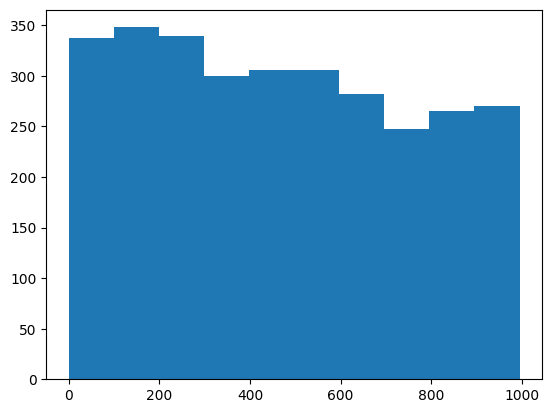

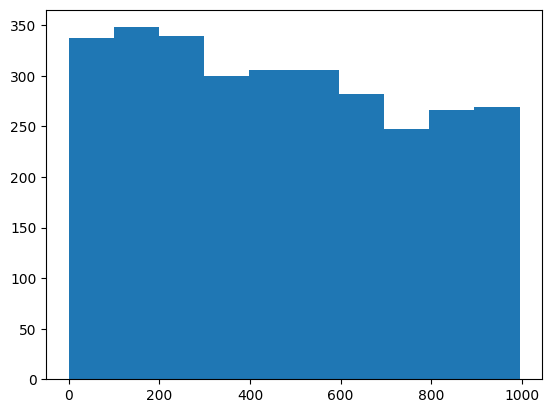

In [14]:

change_per_reaction = abs(samples_default) - abs(samples_default_loopless_solutions)
   
reaction_index = ec_dingo_reactions.index("FRD7")
change_FRD7 = change_per_reaction[reaction_index]

plt.hist(change_FRD7)
plt.show()


reaction_index = ec_dingo_reactions.index("SUCDi")
change_FRD7 = change_per_reaction[reaction_index]

plt.hist(change_FRD7)
plt.show()


### Find how many samples (e.g. percentage) from the initial sampling have significant differences with themselves after applying loopless solution.

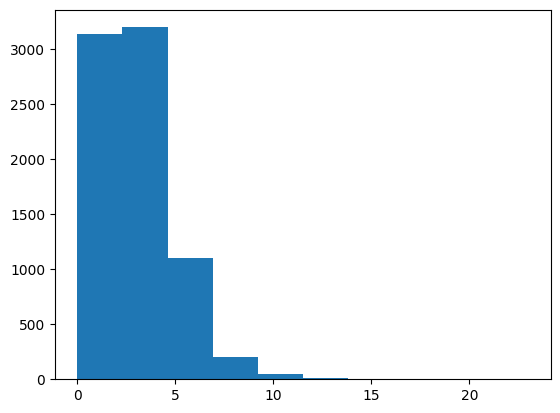

7698 affected samples out of (95, 7700) total samples


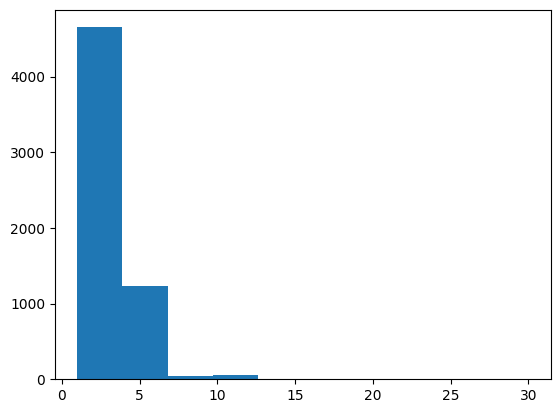

6000 affected samples out of (95, 6000) total samples


In [13]:

affected_reactions_count, total_affected_samples = calculate_affected_samples(samples_default, 
                                                                              samples_default_loopless_solutions, 
                                                                              ec_cobra_model, 
                                                                              tol_reaction_difference=0.5, 
                                                                              tol_reactions_count=1)

plt.hist(affected_reactions_count)
plt.show()
    
print(total_affected_samples, "affected samples out of", (samples_default).shape, "total samples")



affected_reactions_count, total_affected_samples = calculate_affected_samples(samples_frd7_removed, 
                                                                              samples_frd7_removed_loopless_solutions, 
                                                                              ec_cobra_model, 
                                                                              tol_reaction_difference=0.5, 
                                                                              tol_reactions_count=1)

plt.hist(affected_reactions_count)
plt.show()
    
print(total_affected_samples, "affected samples out of", (samples_frd7_removed).shape, "total samples")


### Calculate distances between samples before and after loopless solution (for 3000 samples ==> 3000 distances) and reactions (for 95 reactions ==> 95 distances)

In [15]:

distances_array = calculate_distances_from_reactions(samples_default, samples_default_loopless_solutions, ec_cobra_model)
violin_plot_samples_distances(distances_array)

distances_array = calculate_distances_from_samples(samples_default, samples_default_loopless_solutions, ec_cobra_model)
violin_plot_samples_distances(distances_array)



distances_array = calculate_distances_from_reactions(samples_frd7_removed, samples_frd7_removed_loopless_solutions, ec_cobra_model)
violin_plot_samples_distances(distances_array)

distances_array = calculate_distances_from_samples(samples_frd7_removed, samples_frd7_removed_loopless_solutions, ec_cobra_model)
violin_plot_samples_distances(distances_array)
